# Hppl project
## Image clustering parallelization
### Evgeniy Garsiya, Ivan Anisimov, Victor Adamovich, lina Bashaeva 

# Image clustering (usual implementation)

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from mpi4py import MPI

Text(0.5, 1.0, 'Segmented image, k=4')

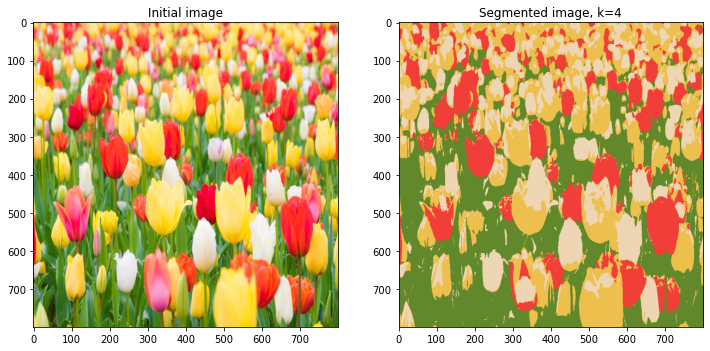

In [184]:

img = cv2.imread('flowers.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(800,800))

pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 4

_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(img.shape)

plt.figure(figsize=(12,10))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img)
ax1.set_title('Initial image')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(segmented_image)
ax2.set_title('Segmented image, k=4')


# Time consumption vs image size (usual implementation)

Text(0.5, 1.0, 'Time consumption vs size (usual implementation)')

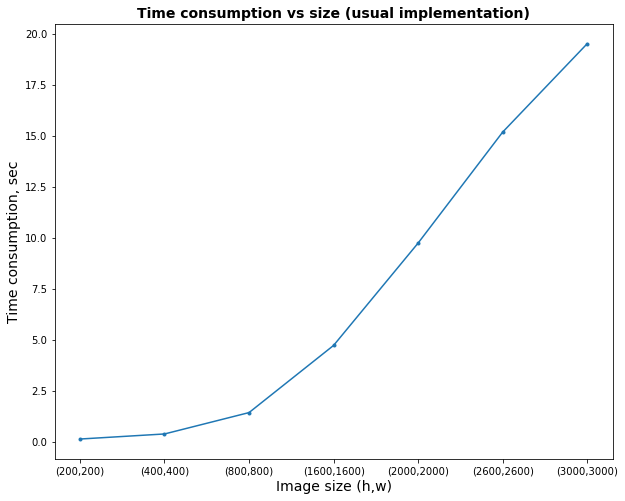

In [195]:
time = []

sizes=[(200,200),(400,400),(800,800),(1600,1600),(2000,2000),(2600,2600),(3000,3000)] 

for size in sizes:
    
    start = MPI.Wtime()
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)

    labels = labels.flatten()
    
    segmented_image = centers[labels.flatten()]
    
    segmented_image = segmented_image.reshape(img.shape)

    end = MPI.Wtime()

    time.append(end-start)

plt.figure(figsize = (10,8))
plt.plot(['(200,200)','(400,400)','(800,800)','(1600,1600)','(2000,2000)','(2600,2600)','(3000,3000)'] ,time, '.-')
plt.xlabel('Image size (h,w)', fontsize = 14)
plt.ylabel('Time consumption, sec', fontsize = 14)
plt.title('Time consumption vs size (usual implementation)', fontsize = 14, fontweight = 'bold')

# Parallel implementation (MPI)

In [187]:
%%writefile cluster_mpi.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def clustering(img_proc):
    
    pixel_values = img_proc.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    labels = labels.flatten()

    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(img_proc.shape)
    
    return segmented_image
    
comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

start=MPI.Wtime()

if rank == 0:
    
    # ___________Load and separate________________
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(800,800))
    
    h, w,_  = img.shape
    
    plt.imshow(img,cmap='gray')
    plt.title('Initial image')
    plt.savefig("cluster_mpi_init.jpg")
    
    step = np.round(h / size)
    img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

else:
    
    img_proc = None
    
img_proc = comm.scatter(img_proc, root=0)


# ___________Image processing and gathering to 0_________

segmented_image = clustering(img_proc)

if rank == 0:
    receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
else:
    receive_buffer = None

comm.Gatherv(segmented_image, receive_buffer, 0)

end=MPI.Wtime()

#________________Image visualization__________________

if rank ==0:

    time=np.float64(end-start)
    np.save("t.npy",time)
    print(f'After {size} processes: Calculation time =  {time} sec')

    plt.imshow((receive_buffer))
    plt.title('Segmented image (MPI)')
    plt.savefig("cluster_mpi.jpg")

Overwriting cluster_mpi.py


In [188]:
!mpirun -n 1 python cluster_mpi.py

After 1 processes: Calculation time =  1.4930058750032913 sec


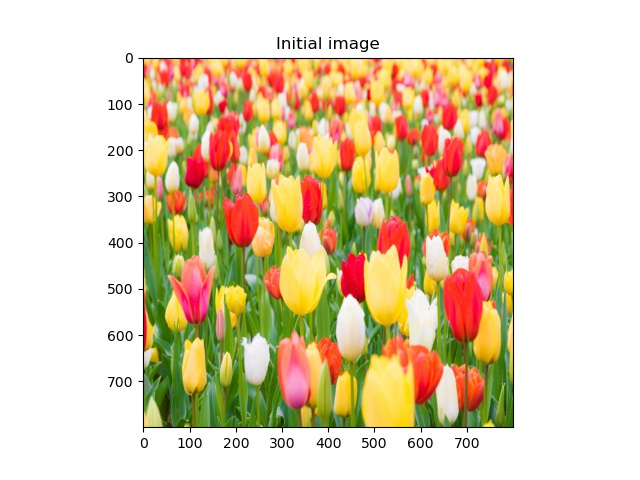

In [189]:
from IPython.display import Image
Image('cluster_mpi_init.jpg')

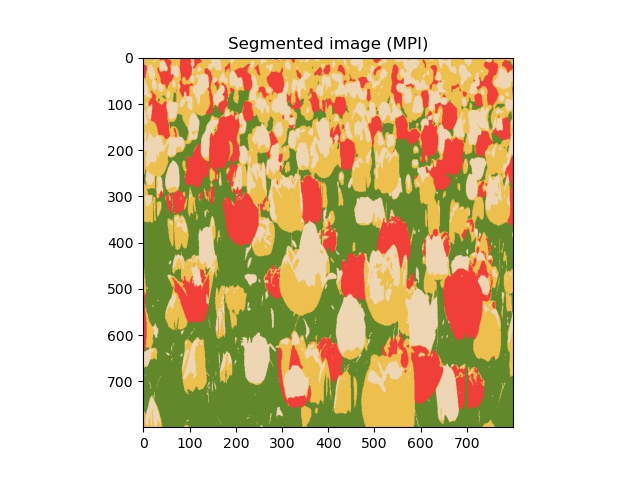

In [190]:
from IPython.display import Image
Image('cluster_mpi.jpg')

# Time consumption vs image size (parallel)

In [196]:
%%writefile cluster_mpi_time_consump.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def clustering(img_proc):
    
    pixel_values = img_proc.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    labels = labels.flatten()

    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(img_proc.shape)
    
    return segmented_image

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

sizes=[(200,200),(400,400),(800,800),(1600,1600),(2000,2000),(2600,2600),(3000,3000)] 
time=[]

for im_size in sizes:
    
    start=MPI.Wtime()

    if rank == 0:

        # ___________Load and separate________________

        img = (cv2.imread('flowers.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,im_size)

        h, w,_  = img.shape

        step = np.round(h / size)
        img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

    else:

        img_proc = None

    img_proc = comm.scatter(img_proc, root=0)


    # ___________Image processing and gathering to 0_________


    segmented_image = clustering(img_proc)

    if rank == 0:
        receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
    else:
        receive_buffer = None

    comm.Gatherv(segmented_image, receive_buffer, 0)

    end=MPI.Wtime()

    #________________Image visualization__________________

    if rank ==0:
        time.append(np.float64(end-start))
if rank ==0:
    np.save("t_consump.npy",np.array(time))

Overwriting cluster_mpi_time_consump.py


In [197]:
!mpirun -n 1 python cluster_mpi_time_consump.py

Text(0.5, 1.0, 'Time consumption vs size (mpi implementation)')

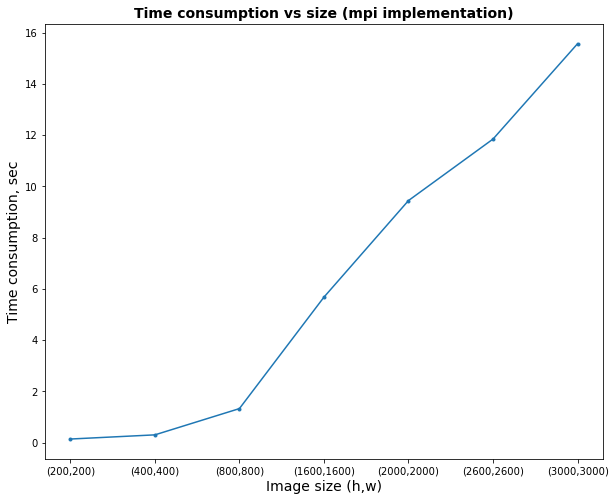

In [198]:
t_consump=np.load('t_consump.npy')
plt.figure(figsize=(10,8))
plt.plot(['(200,200)','(400,400)','(800,800)','(1600,1600)','(2000,2000)','(2600,2600)','(3000,3000)'] ,t_consump, '.-')
plt.xlabel('Image size (h,w)', fontsize = 14)
plt.ylabel('Time consumption, sec', fontsize = 14)
plt.title('Time consumption vs size (mpi implementation)', fontsize = 14, fontweight = 'bold')

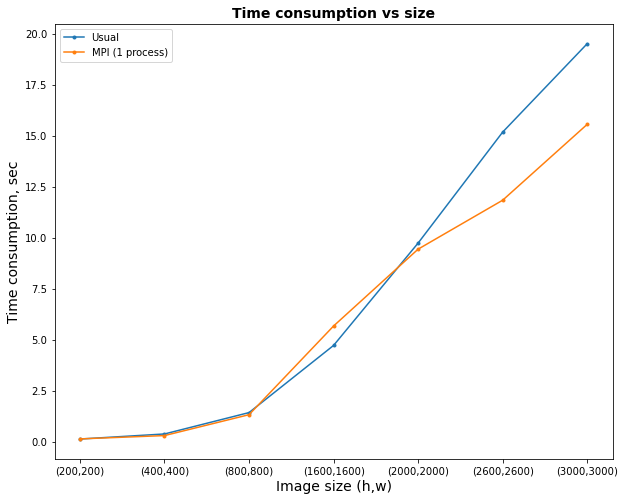

In [199]:
plt.figure(figsize=(10,8))
plt.plot(['(200,200)','(400,400)','(800,800)','(1600,1600)','(2000,2000)','(2600,2600)','(3000,3000)'] ,time, '.-', ['(200,200)','(400,400)','(800,800)','(1600,1600)','(2000,2000)','(2600,2600)','(3000,3000)'] ,t_consump, '.-')
plt.xlabel('Image size (h,w)', fontsize = 14)
plt.ylabel('Time consumption, sec', fontsize = 14)
plt.title('Time consumption vs size', fontsize = 14, fontweight = 'bold')
plt.legend(['Usual','MPI (1 process)'])

# MPI speedup vs number of processes

## Small image, small k

In [159]:
%%writefile cluster_mpi_speedup.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

start=MPI.Wtime()

if rank == 0:
    
    # ___________Load and separate________________
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(600,400))
    
    h, w,_  = img.shape
    
    step = np.round(h / size)
    img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

else:
    
    img_proc = None
    
img_proc = comm.scatter(img_proc, root=0)


# ___________Image processing and gathering to 0_________

pixel_values = img_proc.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(img_proc.shape)

if rank == 0:
    receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
else:
    receive_buffer = None

comm.Gatherv(segmented_image, receive_buffer, 0)

end=MPI.Wtime()

#________________Image visualization__________________

if rank ==0:

    time=np.float64(end-start)
    np.save("t_speedup.npy",time)
    print(f'After {size} processes: Calculation time =  {time} sec')

Overwriting cluster_mpi_speedup.py


After 1 processes: Calculation time =  0.4476473749964498 sec
After 2 processes: Calculation time =  0.302336209002533 sec
After 3 processes: Calculation time =  0.3413698750009644 sec
After 4 processes: Calculation time =  0.2939234579971526 sec
After 5 processes: Calculation time =  0.22996929199871374 sec
After 6 processes: Calculation time =  0.22708895800315076 sec
After 7 processes: Calculation time =  0.25439329199434724 sec
After 8 processes: Calculation time =  0.26482891700288747 sec
After 9 processes: Calculation time =  0.23832187500374857 sec
After 10 processes: Calculation time =  0.2453782919983496 sec
After 11 processes: Calculation time =  0.3609126669980469 sec
After 12 processes: Calculation time =  0.2655830000003334 sec


Text(0.5, 1.0, 'Speedup vs Number of processes. Image size (600x400), k = 3')

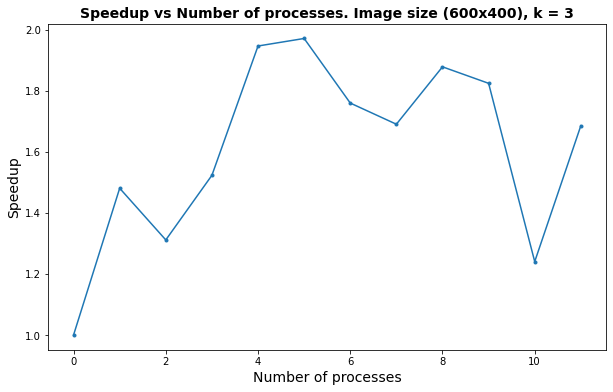

In [161]:
speed=[]

for i in range(1,13):
    !mpirun -n {i} python cluster_mpi_speedup.py
    speed.append(np.float64(np.load("t_speedup.npy")))
    
plt.figure(figsize=(10,6))
plt.plot(range(len(speed)),abs(speed[0]/speed),'.-')
plt.xlabel("Number of processes", fontsize = 14)
plt.ylabel("Speedup", fontsize = 14)
plt.title("Speedup vs Number of processes. Image size (600x400), k = 3", fontsize = 14, fontweight = 'bold')

## Small image, large k

In [162]:
%%writefile cluster_mpi_speedup.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

start=MPI.Wtime()

if rank == 0:
    
    # ___________Load and separate________________
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(600,400))
    
    h, w,_  = img.shape
    
    step = np.round(h / size)
    img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

else:
    
    img_proc = None
    
img_proc = comm.scatter(img_proc, root=0)


# ___________Image processing and gathering to 0_________

pixel_values = img_proc.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 9
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(img_proc.shape)

if rank == 0:
    receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
else:
    receive_buffer = None

comm.Gatherv(segmented_image, receive_buffer, 0)

end=MPI.Wtime()

#________________Image visualization__________________

if rank ==0:

    time=np.float64(end-start)
    np.save("t_speedup.npy",time)
    print(f'After {size} processes: Calculation time =  {time} sec')

Overwriting cluster_mpi_speedup.py


After 1 processes: Calculation time =  1.3468100000027334 sec
After 2 processes: Calculation time =  0.9468514999971376 sec
After 3 processes: Calculation time =  0.9820894169970416 sec
After 4 processes: Calculation time =  1.0425738749981974 sec
After 5 processes: Calculation time =  1.0755691249942174 sec
After 6 processes: Calculation time =  1.0139613330029533 sec
After 7 processes: Calculation time =  0.9550417080026818 sec
After 8 processes: Calculation time =  1.0497159590013325 sec
After 9 processes: Calculation time =  0.998390708999068 sec
After 10 processes: Calculation time =  0.9013399999967078 sec
After 11 processes: Calculation time =  1.0392953330010641 sec
After 12 processes: Calculation time =  0.9668782910011942 sec


Text(0.5, 1.0, 'Speedup vs Number of processes. Image size (600x400), k = 9')

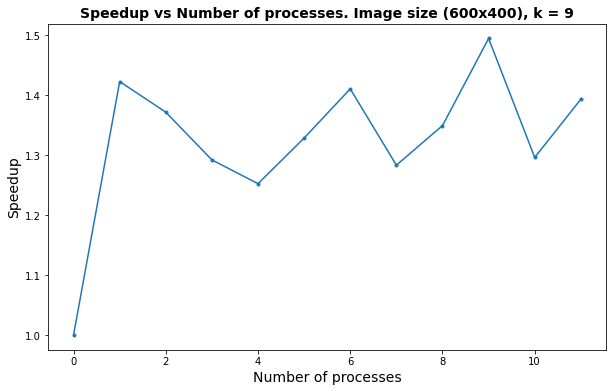

In [163]:
speed=[]

for i in range(1,13):
    !mpirun -n {i} python cluster_mpi_speedup.py
    speed.append(np.float64(np.load("t_speedup.npy")))
    
plt.figure(figsize=(10,6))
plt.plot(range(len(speed)),abs(speed[0]/speed), '.-')
plt.xlabel("Number of processes", fontsize = 14)
plt.ylabel("Speedup", fontsize = 14)
plt.title("Speedup vs Number of processes. Image size (600x400), k = 9", fontsize = 14, fontweight = 'bold')

## Large image, small k

In [210]:
%%writefile cluster_mpi_speedup.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

start=MPI.Wtime()

if rank == 0:
    
    # ___________Load and separate________________
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(2600,2000))
    
    h, w,_  = img.shape
    
    step = np.round(h / size)
    img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

else:
    
    img_proc = None
    
img_proc = comm.scatter(img_proc, root=0)


# ___________Image processing and gathering to 0_________

pixel_values = img_proc.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(img_proc.shape)

if rank == 0:
    receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
else:
    receive_buffer = None

comm.Gatherv(segmented_image, receive_buffer, 0)

end=MPI.Wtime()

#________________Image visualization__________________

if rank ==0:

    time=np.float64(end-start)
    np.save("t_speedup.npy",time)
    print(f'After {size} processes: Calculation time =  {time} sec')

Overwriting cluster_mpi_speedup.py


After 1 processes: Calculation time =  9.188164209001116 sec
After 2 processes: Calculation time =  5.5903775830011 sec
After 3 processes: Calculation time =  5.904592874998343 sec
After 4 processes: Calculation time =  4.630062458003522 sec
After 5 processes: Calculation time =  3.853734208998503 sec
After 6 processes: Calculation time =  3.726350625001942 sec
After 7 processes: Calculation time =  3.833832958996936 sec
After 8 processes: Calculation time =  4.676416458001768 sec
After 9 processes: Calculation time =  3.5618530829960946 sec
After 10 processes: Calculation time =  3.624692874996981 sec
After 11 processes: Calculation time =  3.244850208000571 sec
After 12 processes: Calculation time =  3.7368224169986206 sec


Text(0.5, 1.0, 'Speedup vs Number of processes. Image size (2600x2000), k = 3')

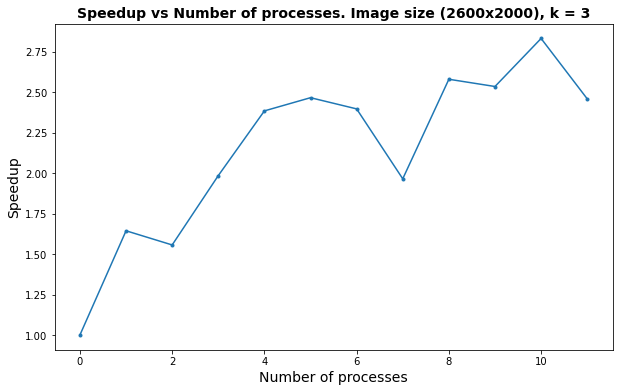

In [213]:
speed=[]

for i in range(1,13):
    !mpirun -n {i} python cluster_mpi_speedup.py
    speed.append(np.float64(np.load("t_speedup.npy")))
    
plt.figure(figsize=(10,6))
plt.plot(range(len(speed)),abs(speed[0]/speed), '.-')
plt.xlabel("Number of processes", fontsize = 14)
plt.ylabel("Speedup", fontsize = 14)
plt.title("Speedup vs Number of processes. Image size (2600x2000), k = 3", fontsize = 14, fontweight = 'bold')

## Large image, large k 

In [204]:
%%writefile cluster_mpi_speedup.py

from mpi4py import MPI
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

start=MPI.Wtime()

if rank == 0:
    
    # ___________Load and separate________________
    
    img = (cv2.imread('flowers.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(2600,2000))
    
    h, w,_  = img.shape
    
    step = np.round(h / size)
    img_proc = [img[int((r * step)): int(((r + 1) * step))] for r in range(size)]

else:
    
    img_proc = None
    
img_proc = comm.scatter(img_proc, root=0)


# ___________Image processing and gathering to 0_________

pixel_values = img_proc.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 9
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(img_proc.shape)

if rank == 0:
    receive_buffer = np.empty((segmented_image.shape[0]*size, segmented_image.shape[1],3), dtype=np.uint8)
else:
    receive_buffer = None

comm.Gatherv(segmented_image, receive_buffer, 0)

end=MPI.Wtime()

#________________Image visualization__________________

if rank ==0:

    time=np.float64(end-start)
    np.save("t_speedup.npy",time)
    print(f'After {size} processes: Calculation time =  {time} sec')

Overwriting cluster_mpi_speedup.py


After 1 processes: Calculation time =  30.471253625000827 sec
After 2 processes: Calculation time =  25.2869835829988 sec
After 3 processes: Calculation time =  22.649371167004574 sec
After 4 processes: Calculation time =  23.947742874996038 sec
After 5 processes: Calculation time =  23.86525137499848 sec
After 6 processes: Calculation time =  21.899989332996483 sec
After 7 processes: Calculation time =  22.344904334000603 sec
After 8 processes: Calculation time =  19.22166329099855 sec
After 9 processes: Calculation time =  22.759520291998342 sec
After 10 processes: Calculation time =  19.895049124999787 sec
After 11 processes: Calculation time =  19.098684583994327 sec
After 12 processes: Calculation time =  18.170624625003256 sec


Text(0.5, 1.0, 'Speedup vs Number of processes. Image size (2600x2000), k = 9')

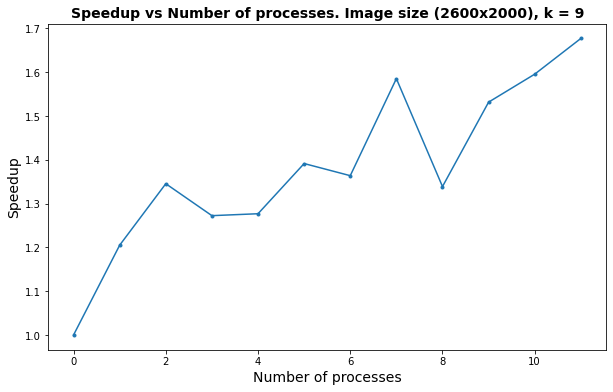

In [166]:
speed=[]

for i in range(1,13):
    !mpirun -n {i} python cluster_mpi_speedup.py
    speed.append(np.float64(np.load("t_speedup.npy")))
    
plt.figure(figsize=(10,6))
plt.plot(range(len(speed)),abs(speed[0]/speed),'.-')
plt.xlabel("Number of processes", fontsize = 14)
plt.ylabel("Speedup", fontsize = 14)
plt.title("Speedup vs Number of processes. Image size (2600x2000), k = 9", fontsize = 14, fontweight = 'bold')